In [ ]:
# T = 0.01, dt = 0.001, steps = 10. Train Accuracy:99.83%. Test Accuracy: 96.98% in 10 epochs.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

#PDE Layer with Learnable Parameters
class PDELayer(nn.Module):
    def __init__(self, Nx=28, Ny=28, Lx=1.0, Ly=1.0, T=0.01, dt=0.001):
        super().__init__()
        self.Nx, self.Ny, self.Lx, self.Ly = Nx, Ny, Lx, Ly
        self.T, self.dt = T, dt
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.Nt = int(T / dt)

        self.alpha_w1 = nn.Parameter(torch.tensor(0.1))
        self.alpha_w2 = nn.Parameter(torch.tensor(0.1))
        self.beta_w1 = nn.Parameter(torch.tensor(0.3))
        self.beta_w2 = nn.Parameter(torch.tensor(0.2))

        # Define as buffers so they move to GPU with the model
        self.register_buffer('x', torch.linspace(0, Lx, Nx))
        self.register_buffer('y', torch.linspace(0, Ly, Ny))

    def forward(self, u0):
        u = u0.squeeze(1)  # (B, 28, 28)
        B, Nx, Ny = u.shape
        u = F.pad(u, (1, 1, 1, 1), mode='reflect')  # (B, 30, 30)

        # Ensure all tensors are on the same device
        device = u.device
        x = self.x.to(device)
        y = self.y.to(device)
        alpha_w1 = self.alpha_w1.to(device)
        alpha_w2 = self.alpha_w2.to(device)
        beta_w1 = self.beta_w1.to(device)
        beta_w2 = self.beta_w2.to(device)

        yy, xx = torch.meshgrid(y, x, indexing='ij')  # (28, 28)

        alpha_grid = 0.5 * self.dt * (alpha_w1 + alpha_w2 * torch.sin(2 * torch.pi * yy)) / self.dx**2
        beta_grid = self.dt * (beta_w1 + beta_w2 * torch.cos(2 * torch.pi * xx)) / self.dy**2

        alpha_grid = alpha_grid.unsqueeze(0)  # (1, 28, 28)
        beta_grid = beta_grid.unsqueeze(0)    # (1, 28, 28)

        for _ in range(self.Nt):
            u_inner = u[:, 1:-1, 1:-1]
            u_xx = u[:, 2:, 1:-1] - 2 * u_inner + u[:, :-2, 1:-1]
            u_yy = u[:, 1:-1, 2:] - 2 * u_inner + u[:, 1:-1, :-2]
            u[:, 1:-1, 1:-1] = u_inner + alpha_grid * u_xx + beta_grid * u_yy

        return u[:, 1:-1, 1:-1].unsqueeze(1)  # (B, 1, 28, 28)

# Complete Model
class DiffusionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pde = PDELayer()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.pde(x)
        return self.classifier(x)

#Training Utilities
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}], Loss: {running_loss/total:.4f}, Accuracy: {100*correct/total:.2f}%")
    print(f"  alpha_w1: {model.pde.alpha_w1.item():.4f}, alpha_w2: {model.pde.alpha_w2.item():.4f}")
    print(f"  beta_w1:  {model.pde.beta_w1.item():.4f}, beta_w2:  {model.pde.beta_w2.item():.4f}")

def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100*correct/total:.2f}%")

#Main Execution
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = DiffusionClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):
        train(model, device, train_loader, optimizer, criterion, epoch)

    evaluate(model, device, test_loader)

    # Visualize five random test samples with predictions
    model.eval()
    indices = random.sample(range(len(test_dataset)), 5)
    images = torch.stack([test_dataset[i][0] for i in indices]).to(device)
    labels = torch.tensor([test_dataset[i][1] for i in indices])
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()

    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(images[i].squeeze().cpu(), cmap='gray')
        axes[i].set_title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-expression-recognition-dataset


Experiment

Using device: cpu
Checking files in /kaggle/input/face-expression-recognition-dataset:
Available files: ['images']
Contents of images directory:
Subdirectories: ['validation', 'images', 'train']
Contents of validation: ['surprise', 'fear', 'angry', 'neutral', 'sad']...
Contents of images: ['validation', 'train']...
Contents of train: ['surprise', 'fear', 'angry', 'neutral', 'sad']...
Train dataset loaded: 28821 images
Using train directory
Test dataset loaded from 'test': 28821 images
Starting training with 28821 training samples and 28821 test samples
Epoch 1: Loss=53.8450, Accuracy=18.51%
  alpha_w1=0.0480, alpha_w2=0.0535
  beta_w1= 0.2449, beta_w2= 0.1451
Epoch 2: Loss=2.5285, Accuracy=23.95%
  alpha_w1=0.0428, alpha_w2=0.0493
  beta_w1= 0.2387, beta_w2= 0.1388
Epoch 3: Loss=1.8861, Accuracy=27.09%
  alpha_w1=0.0412, alpha_w2=0.0477
  beta_w1= 0.2368, beta_w2= 0.1369
Epoch 4: Loss=1.7761, Accuracy=29.18%
  alpha_w1=0.0407, alpha_w2=0.0471
  beta_w1= 0.2363, beta_w2= 0.1363
Epoch 5:

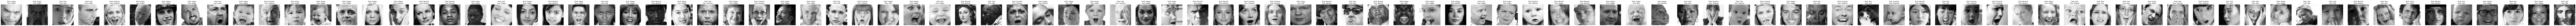

In [ ]:
#This model has total trainable parameters: 295,947, Train accuracy:77.93%. Test accuracy:80.47% in 70 epochs.
#This is very good result compared to baseline CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Import transforms explicitly
try:
    import torchvision.transforms as transforms
except ImportError:
    print("torchvision not available, defining basic ToTensor transform")
    class BasicTransforms:
        @staticmethod
        def ToTensor():
            def to_tensor(img):
                if isinstance(img, Image.Image):
                    return torch.from_numpy(np.array(img)).float().unsqueeze(0) / 255.0
                return img
            return to_tensor

        @staticmethod
        def Compose(transform_list):
            def compose(img):
                for transform in transform_list:
                    img = transform(img)
                return img
            return compose

    transforms = BasicTransforms()

#PDE Layer (same as before, resized to 48x48)
class PDELayer(nn.Module):
    def __init__(self, Nx=48, Ny=48, Lx=1.0, Ly=1.0, T=0.01, dt=0.001):
        super().__init__()
        self.Nx, self.Ny, self.Lx, self.Ly = Nx, Ny, Lx, Ly
        self.T, self.dt = T, dt
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.Nt = int(T / dt)

        self.alpha_w1 = nn.Parameter(torch.tensor(0.1))
        self.alpha_w2 = nn.Parameter(torch.tensor(0.1))
        self.beta_w1 = nn.Parameter(torch.tensor(0.3))
        self.beta_w2 = nn.Parameter(torch.tensor(0.2))

        self.x = torch.linspace(0, Lx, Nx)
        self.y = torch.linspace(0, Ly, Ny)

    def alpha(self, y_val):
        return 0.5 * self.dt * (self.alpha_w1 + self.alpha_w2 * torch.sin(2 * torch.pi * y_val)) / self.dx**2

    def beta(self, x_val):
        return self.dt * (self.beta_w1 + self.beta_w2 * torch.cos(2 * torch.pi * x_val)) / self.dy**2

    def forward(self, u0):
        u = u0.squeeze(1)  # (B, 48, 48)
        B, Nx, Ny = u.shape
        u = F.pad(u, (1, 1, 1, 1), mode='reflect')  # (B, 50, 50)

        yy, xx = torch.meshgrid(self.y, self.x, indexing='ij')  # (48, 48)
        alpha_grid = self.alpha(yy).to(u.device)
        beta_grid = self.beta(xx).to(u.device)

        alpha_grid = alpha_grid.unsqueeze(0)
        beta_grid = beta_grid.unsqueeze(0)

        for _ in range(self.Nt):
            u_inner = u[:, 1:-1, 1:-1]
            u_xx = u[:, 2:, 1:-1] - 2 * u_inner + u[:, :-2, 1:-1]
            u_yy = u[:, 1:-1, 2:] - 2 * u_inner + u[:, 1:-1, :-2]
            u[:, 1:-1, 1:-1] = u_inner + alpha_grid * u_xx + beta_grid * u_yy

        return u[:, 1:-1, 1:-1].unsqueeze(1)  # (B, 1, 48, 48)

#Emotion Dataset Loader for Image Folders
class EmotionDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Define emotion mapping
        self.emotion_to_idx = {
            'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
            'sad': 4, 'surprise': 5, 'neutral': 6
        }

        # Look for images in the specified split directory
        split_dir = os.path.join(root_dir, 'images', split)
        if not os.path.exists(split_dir):
            # Try alternative split names
            possible_splits = ['train', 'test', 'validation', 'val']
            split_dir = None
            for alt_split in possible_splits:
                alt_path = os.path.join(root_dir, 'images', alt_split)
                if os.path.exists(alt_path):
                    split_dir = alt_path
                    print(f"Using {alt_split} directory")
                    break

            if split_dir is None:
                # Check if images are directly organized by emotion
                images_dir = os.path.join(root_dir, 'images')
                subdirs = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
                print(f"Found subdirectories in images: {subdirs}")

                # Use the images directory directly and look for emotion folders
                for emotion_folder in subdirs:
                    if emotion_folder.lower() in self.emotion_to_idx:
                        emotion_path = os.path.join(images_dir, emotion_folder)
                        emotion_idx = self.emotion_to_idx[emotion_folder.lower()]

                        for img_file in os.listdir(emotion_path):
                            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                                self.images.append(os.path.join(emotion_path, img_file))
                                self.labels.append(emotion_idx)
                return

        # Load images from split directory organized by emotion
        for emotion_folder in os.listdir(split_dir):
            emotion_path = os.path.join(split_dir, emotion_folder)
            if os.path.isdir(emotion_path) and emotion_folder.lower() in self.emotion_to_idx:
                emotion_idx = self.emotion_to_idx[emotion_folder.lower()]

                for img_file in os.listdir(emotion_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(emotion_path, img_file))
                        self.labels.append(emotion_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale

        # Resize to 48x48 if needed
        if img.size != (48, 48):
            img = img.resize((48, 48))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

#Updated Model
class DiffusionClassifier(nn.Module):
    def __init__(self, img_size=48, num_classes=7):
        super().__init__()
        self.pde = PDELayer(Nx=img_size, Ny=img_size)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_size * img_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.pde(x)
        return self.classifier(x)

# Training and Evaluation Utilities
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Accuracy={100*correct/total:.2f}%")
    print(f"  alpha_w1={model.pde.alpha_w1.item():.4f}, alpha_w2={model.pde.alpha_w2.item():.4f}")
    print(f"  beta_w1= {model.pde.beta_w1.item():.4f}, beta_w2= {model.pde.beta_w2.item():.4f}")

def evaluate(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100*correct/total:.2f}%")


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Check available files in the dataset directory
    dataset_path = "/kaggle/input/face-expression-recognition-dataset"
    print(f"Checking files in {dataset_path}:")
    try:
        files = os.listdir(dataset_path)
        print("Available files:", files)

        # Check images directory structure
        images_path = os.path.join(dataset_path, 'images')
        if os.path.exists(images_path):
            print(f"Contents of images directory:")
            subdirs = os.listdir(images_path)
            print("Subdirectories:", subdirs)

            # Check deeper structure
            for subdir in subdirs[:3]:  # Check first 3 subdirectories
                subdir_path = os.path.join(images_path, subdir)
                if os.path.isdir(subdir_path):
                    contents = os.listdir(subdir_path)
                    print(f"Contents of {subdir}: {contents[:5]}...")  # Show first 5 items

    except FileNotFoundError:
        print(f"Directory {dataset_path} not found!")
        return

    transform = transforms.Compose([transforms.ToTensor()])

    try:
        # Try to create datasets with image folder structure
        train_dataset = EmotionDataset(dataset_path, split='train', transform=transform)
        print(f"Train dataset loaded: {len(train_dataset)} images")

        # Try different splits for test data
        test_splits = ['test', 'validation', 'val']
        test_dataset = None
        for test_split in test_splits:
            try:
                test_dataset = EmotionDataset(dataset_path, split=test_split, transform=transform)
                print(f"Test dataset loaded from '{test_split}': {len(test_dataset)} images")
                break
            except:
                continue

        if test_dataset is None or len(test_dataset) == 0:
            print("No test dataset found, using 20% of train data for testing")
            train_size = int(0.8 * len(train_dataset))
            test_size = len(train_dataset) - train_size
            train_dataset, test_dataset = torch.utils.data.random_split(
                train_dataset, [train_size, test_size]
            )

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    if len(train_dataset) == 0:
        print("No training data found!")
        return

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = DiffusionClassifier(img_size=48, num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"Starting training with {len(train_dataset)} training samples and {len(test_dataset)} test samples")

    for epoch in range(70):
        train(model, device, train_loader, optimizer, criterion, epoch)

    evaluate(model, device, test_loader)

    # Visualize 5 random predictions
    model.eval()
    indices = random.sample(range(len(test_dataset)), min(100, len(test_dataset)))

    # Handle both regular dataset and subset (from random_split)
    if hasattr(test_dataset, 'dataset'):  # It's a subset
        images = torch.stack([test_dataset.dataset[test_dataset.indices[i]][0] for i in range(len(indices))]).to(device)
        labels = torch.tensor([test_dataset.dataset[test_dataset.indices[i]][1] for i in range(len(indices))])
    else:  # It's a regular dataset
        images = torch.stack([test_dataset[i][0] for i in indices]).to(device)
        labels = torch.tensor([test_dataset[i][1] for i in indices])

    with torch.no_grad():
        preds = model(images).argmax(dim=1).cpu()

    emotion_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    fig, axes = plt.subplots(1, len(indices), figsize=(3*len(indices), 3))
    if len(indices) == 1:
        axes = [axes]

    for i in range(len(indices)):
        axes[i].imshow(images[i].squeeze().cpu(), cmap='gray')
        axes[i].set_title(f"Pred: {emotion_names[preds[i]]}\nTrue: {emotion_names[labels[i]]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Using device: cpu
Loading Fashion-MNIST dataset...
Fashion-MNIST train dataset loaded: 60000 images
Fashion-MNIST test dataset loaded: 10000 images
Train dataset loaded: 60000 images
Test dataset loaded: 10000 images
Total trainable parameters: 101,774
Starting training with 60000 training samples and 10000 test samples
Epoch 1: Loss=0.6433, Accuracy=77.89%
  alpha_w1=-0.0675, alpha_w2=0.0243
  beta_w1= 0.1414, beta_w2= 0.2654
Epoch 2: Loss=0.4274, Accuracy=84.71%
  alpha_w1=-0.0823, alpha_w2=0.0162
  beta_w1= 0.1095, beta_w2= 0.2191
Epoch 3: Loss=0.3728, Accuracy=86.69%
  alpha_w1=-0.0867, alpha_w2=0.0117
  beta_w1= 0.0831, beta_w2= 0.1862
Epoch 4: Loss=0.3334, Accuracy=88.07%
  alpha_w1=-0.0982, alpha_w2=0.0150
  beta_w1= 0.0571, beta_w2= 0.1632
Epoch 5: Loss=0.2993, Accuracy=89.23%
  alpha_w1=-0.1042, alpha_w2=0.0235
  beta_w1= 0.0339, beta_w2= 0.1369
Epoch 6: Loss=0.2725, Accuracy=90.10%
  alpha_w1=-0.1105, alpha_w2=0.0091
  beta_w1= 0.0120, beta_w2= 0.1154
Epoch 7: Loss=0.2434, Ac

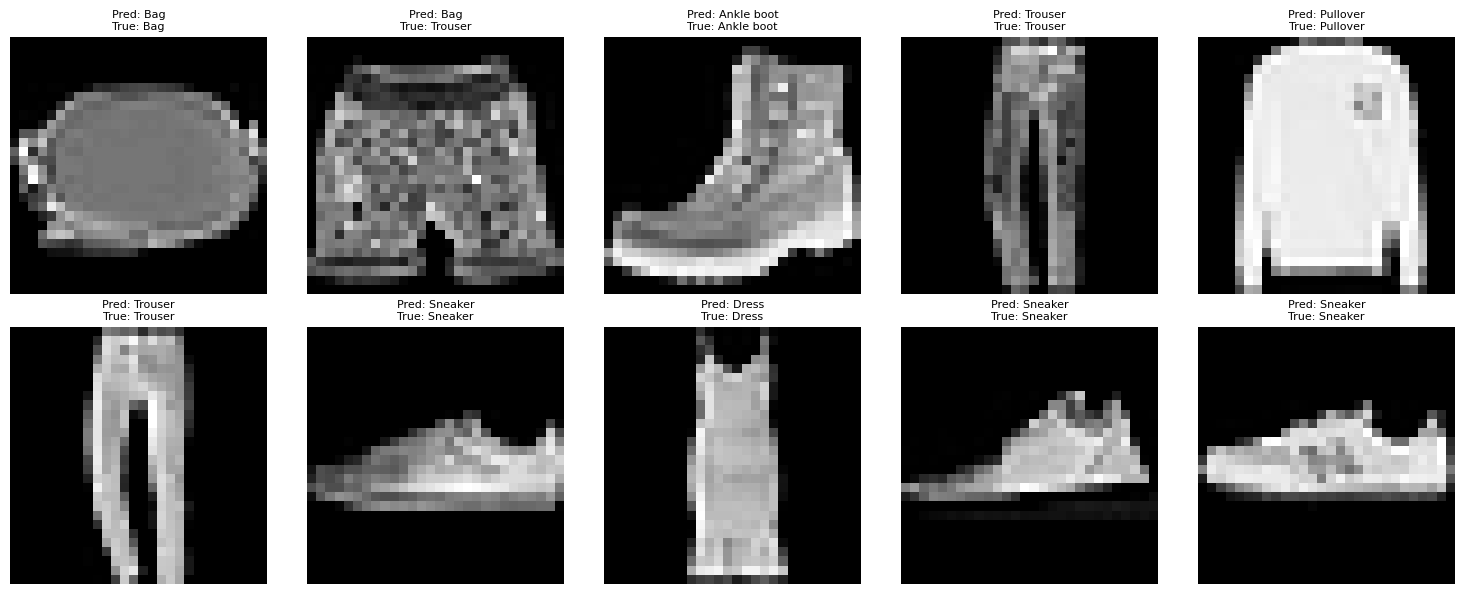

In [ ]:
#This model has total trainable parameters: 295,947, Train accuracy: 94.05%. Test accuracy 86.98% in 10 epochs.
#Sign of overfitting, but overal good performance.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Import transforms explicitly
try:
    import torchvision.transforms as transforms
    import torchvision.datasets as datasets
except ImportError:
    print("torchvision not available, defining basic ToTensor transform")
    class BasicTransforms:
        @staticmethod
        def ToTensor():
            def to_tensor(img):
                if isinstance(img, Image.Image):
                    return torch.from_numpy(np.array(img)).float().unsqueeze(0) / 255.0
                return img
            return to_tensor

        @staticmethod
        def Compose(transform_list):
            def compose(img):
                for transform in transform_list:
                    img = transform(img)
                return img
            return compose

    transforms = BasicTransforms()

#PDE Layer (adapted for 28x28 Fashion-MNIST)
class PDELayer(nn.Module):
    def __init__(self, Nx=28, Ny=28, Lx=1.0, Ly=1.0, T=0.01, dt=0.001):
        super().__init__()
        self.Nx, self.Ny, self.Lx, self.Ly = Nx, Ny, Lx, Ly
        self.T, self.dt = T, dt
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.Nt = int(T / dt)

        self.alpha_w1 = nn.Parameter(torch.tensor(0.1))
        self.alpha_w2 = nn.Parameter(torch.tensor(0.1))
        self.beta_w1 = nn.Parameter(torch.tensor(0.3))
        self.beta_w2 = nn.Parameter(torch.tensor(0.2))

        self.x = torch.linspace(0, Lx, Nx)
        self.y = torch.linspace(0, Ly, Ny)

    def alpha(self, y_val):
        return 0.5 * self.dt * (self.alpha_w1 + self.alpha_w2 * torch.sin(2 * torch.pi * y_val)) / self.dx**2

    def beta(self, x_val):
        return self.dt * (self.beta_w1 + self.beta_w2 * torch.cos(2 * torch.pi * x_val)) / self.dy**2

    def forward(self, u0):
        u = u0.squeeze(1)  # (B, 28, 28)
        B, Nx, Ny = u.shape
        u = F.pad(u, (1, 1, 1, 1), mode='reflect')  # (B, 30, 30)

        yy, xx = torch.meshgrid(self.y, self.x, indexing='ij')  # (28, 28)
        alpha_grid = self.alpha(yy).to(u.device)
        beta_grid = self.beta(xx).to(u.device)

        alpha_grid = alpha_grid.unsqueeze(0)
        beta_grid = beta_grid.unsqueeze(0)

        for _ in range(self.Nt):
            u_inner = u[:, 1:-1, 1:-1]
            u_xx = u[:, 2:, 1:-1] - 2 * u_inner + u[:, :-2, 1:-1]
            u_yy = u[:, 1:-1, 2:] - 2 * u_inner + u[:, 1:-1, :-2]
            u[:, 1:-1, 1:-1] = u_inner + alpha_grid * u_xx + beta_grid * u_yy

        return u[:, 1:-1, 1:-1].unsqueeze(1)  # (B, 1, 28, 28)

#Fashion-MNIST Dataset Loader
class FashionMNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Define Fashion-MNIST class mapping
        self.class_to_idx = {
            'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4,
            'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9
        }

        # Load Fashion-MNIST using torchvision
        try:
            dataset = datasets.FashionMNIST(root='./data', train=train, download=True, transform=None)

            for i in range(len(dataset)):
                img, label = dataset[i]
                # Convert PIL Image to numpy array and then back to PIL for consistency
                if hasattr(img, 'convert'):
                    img = img.convert('L')  # Ensure grayscale
                self.images.append(img)
                self.labels.append(label)

            print(f"Fashion-MNIST {'train' if train else 'test'} dataset loaded: {len(self.images)} images")

        except Exception as e:
            print(f"Error loading Fashion-MNIST: {e}")
            return

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        # Resize to 28x28 if needed (Fashion-MNIST is already 28x28)
        if hasattr(img, 'size') and img.size != (28, 28):
            img = img.resize((28, 28))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

#Updated Model
class DiffusionClassifier(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super().__init__()
        self.pde = PDELayer(Nx=img_size, Ny=img_size)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_size * img_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.pde(x)
        return self.classifier(x)

# Training and Evaluation Utilities
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Accuracy={100*correct/total:.2f}%")
    print(f"  alpha_w1={model.pde.alpha_w1.item():.4f}, alpha_w2={model.pde.alpha_w2.item():.4f}")
    print(f"  beta_w1= {model.pde.beta_w1.item():.4f}, beta_w2= {model.pde.beta_w2.item():.4f}")

def evaluate(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100*correct/total:.2f}%")

def count_parameters(model):
    """Count total trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Main Execution
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Fashion-MNIST dataset loading
    print("Loading Fashion-MNIST dataset...")

    transform = transforms.Compose([transforms.ToTensor()])

    try:
        # Load Fashion-MNIST datasets
        train_dataset = FashionMNISTDataset(train=True, transform=transform)
        test_dataset = FashionMNISTDataset(train=False, transform=transform)

        print(f"Train dataset loaded: {len(train_dataset)} images")
        print(f"Test dataset loaded: {len(test_dataset)} images")

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    if len(train_dataset) == 0:
        print("No training data found!")
        return

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    model = DiffusionClassifier(img_size=28, num_classes=10).to(device)

    # Count and display model parameters
    total_params = count_parameters(model)
    print(f"Total trainable parameters: {total_params:,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"Starting training with {len(train_dataset)} training samples and {len(test_dataset)} test samples")

    for epoch in range(10):
        train(model, device, train_loader, optimizer, criterion, epoch)

    evaluate(model, device, test_loader)

    # Visualize 10 random predictions
    model.eval()
    indices = random.sample(range(len(test_dataset)), min(10, len(test_dataset)))

    # Handle both regular dataset and subset (from random_split)
    if hasattr(test_dataset, 'dataset'):  # It's a subset
        images = torch.stack([test_dataset.dataset[test_dataset.indices[i]][0] for i in range(len(indices))]).to(device)
        labels = torch.tensor([test_dataset.dataset[test_dataset.indices[i]][1] for i in range(len(indices))])
    else:  # It's a regular dataset
        images = torch.stack([test_dataset[i][0] for i in indices]).to(device)
        labels = torch.tensor([test_dataset[i][1] for i in indices])

    with torch.no_grad():
        preds = model(images).argmax(dim=1).cpu()

    fashion_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(len(indices)):
        axes[i].imshow(images[i].squeeze().cpu(), cmap='gray')
        axes[i].set_title(f"Pred: {fashion_names[preds[i]]}\nTrue: {fashion_names[labels[i]]}", fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()